# 2D prediction for the entire Kevitsa deposit

In [11]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np 
import pandas as pd 
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable


In [2]:
two_composite_filtered = pd.read_csv("Curated_data/two_composite_filtered.csv", low_memory=False)

- Iteration 0, MSE : 1.05
- Iteration 100, MSE : 0.00
- Iteration 200, MSE : 0.00
- Iteration 300, MSE : 0.00
- Iteration 400, MSE : 0.00


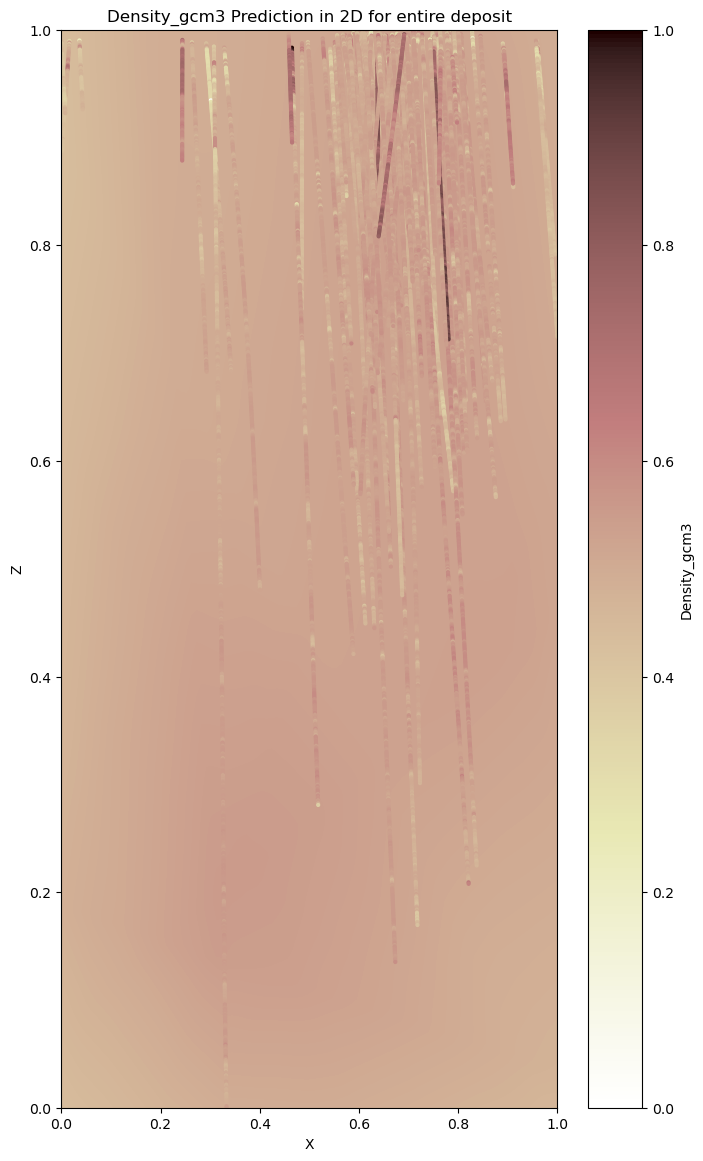

In [19]:
from sklearn.preprocessing import MinMaxScaler
mineral = 'Density_gcm3'
two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_1mineral.dropna(subset=[mineral])
    
  
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Define the columns to normalize
columns_to_normalize = ['X','Y', 'Z', mineral]  # Add all columns you want to normalize

# Fit the scaler to your data and transform the specified columns
two_composite_1mineral[columns_to_normalize] = scaler.fit_transform(two_composite_1mineral[columns_to_normalize])


x = two_composite_1mineral[['X', 'Z']].values  # Use X and Y coordinates
y = two_composite_1mineral[mineral].values[:, np.newaxis]  # Keep mineral as the output
x = x.reshape(len(two_composite_1mineral),2)

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

model = nn.Sequential(
nn.Linear(in_features=2, out_features=200),  
nn.ReLU(),
nn.Linear(in_features=200, out_features=1)
)

mse_loss = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

for step in range(500):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse 
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if step % 100 == 0:
        print('- Iteration %d, MSE : %2.2f' % (step, mse.item()))



# Define a grid of points for prediction
x_grid_hole = np.linspace(x[:, 0].min(), x[:, 0].max(), 100)
y_grid_hole = np.linspace(x[:, 1].min(), x[:, 1].max(), 100)
xv_hole, yv_hole = np.meshgrid(x_grid_hole, y_grid_hole)
xy_grid_hole = np.c_[xv_hole.ravel(), yv_hole.ravel()]

# Make predictions for the grid
predictions_hole = model(torch.tensor(xy_grid_hole, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions_hole = predictions_hole.data.numpy().reshape(xv_hole.shape)


# Pool the values from predictions_hole and y_hole
pooled_values = np.concatenate([predictions_hole.ravel(), y.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

# Create a ScalarMappable for both plots using the same criteria
sm = ScalarMappable(cmap='pink_r')
sm.set_array([])  # Set an empty array to enforce the same vmin and vmax
sm.set_clim(vmin, vmax)  # Set the same vmin and vmax

plt.figure(figsize=(8, 14))

contour_hole = plt.contourf(xv_hole, yv_hole, predictions_hole, cmap='pink_r', vmin=vmin, vmax=vmax, levels=500)  # Adjust levels as needed
scatter = plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), cmap='pink_r', vmin=vmin, vmax=vmax, s=4, label='Selected Hole Data')

# Optionally, you can scatter plot the data points for this specific hole

# Add a colorbar associated with both plots
cb = plt.colorbar(sm, label=mineral)

# Set the color mapping based on the scatter plot

plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'{mineral} Prediction in 2D for entire deposit')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extract the X and Y coordinates
x_y_data = two_composite_1mineral[['X', 'Y']]

# Create a scatter plot of the X and Y coordinates
plt.figure(figsize=(14, 8))
plt.scatter(x_y_data['X'], x_y_data['Y'], s=4)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X and Y Coordinates')
plt.show()